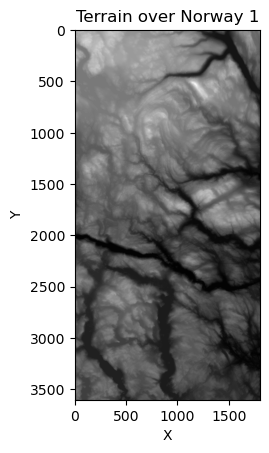

In [4]:
#Import necessary libraries
import numpy as np
from imageio.v2 import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import rasterio

#Load the terraina
terrain1 = imread('SRTM_data_Norway_1.tif')

#Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Calculate MSE from OLS

In [ ]:
#Gets the dimmentions of the data
n_row, n_col = terrain1.shape

#Creates a meshgrid
x = np.linspace(0, n_col-1, n_col)
y = np.linspace(0, n_row-1, n_row)
x, y = np.meshgrid(x,y)

#Coverts the 2D arrays created in the meshgrid to 1D vectors. 
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = terrain1.flatten()

#Splits the data into training and test sets, where the test set consists of 20% of the data. Using tthe train_test_split from scikit-learn. 
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split( x_flat, y_flat, z_flat, test_size=0.2, random_state=0)

#Combines the x and y data to 2D arrays
xy_train = np.vstack((x_train, y_train)).T
xy_test = np.vstack((x_test, y_test)).T

#Scales the data using StandardScaler from Scikit-learn. 
scaler = StandardScaler()

#The fit-function means that the data is scaled based on the training data.
xy_train_scaled = scaler.fit_transform(xy_train)
xy_test_scaled = scaler.transform(xy_test)

#Sets the degree of the polynominal
degrees = np.arange(1,11)

#Creates empty lists to store MS and R2-score
mse_train_values = []
mse_test_values = []
r2_train_values = []
r2_test_values = []

#Define functions for calculating mean squared error. This code is from the lecture notes week 35.
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2) / n

#Defines a function for calculating R2-score. This code is from the lecture notes week 35.
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model)**2) / np.sum((y_data - np.mean(y_data))**2)  #Lecture notes week 35

#For-loop to calculate MSE and R2-score based on the polynomial degree. 
#This code is deriveted from lecture notes week 35. 
for deg in degrees:
    #Fits the function to polynomial to the features.
    poly = PolynomialFeatures(degree=deg)
    X_train = poly.fit_transform(xy_train_scaled)
    X_test = poly.transform(xy_test_scaled)

    #Generate the coefficients using matrix inversion, assumes that X.T@X is invertible
    OLSbeta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train

    #Calculates the predictions
    z_train_pred = X_train @ OLSbeta
    z_test_pred = X_test @ OLSbeta

    #Calculate MSE and R2-score for both training and test data
    mse_train = MSE(z_train, z_train_pred)
    mse_test = MSE(z_test, z_test_pred)
    r2_train = R2(z_train, z_train_pred)
    r2_test = R2(z_test, z_test_pred)

    #Store the results
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)
    r2_train_values.append(r2_train)
    r2_test_values.append(r2_test)

#Plotting MSE and R². The plot for the coefficients got too messy. 
plt.figure(figsize=(18, 7))

#MSE Plot
plt.subplot(1, 3, 1)
plt.plot(degrees, mse_train_values, label='Train MSE', marker='o')
plt.plot(degrees, mse_test_values, label='Test MSE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree')
plt.grid(True)
plt.legend()
plt.show

#R² Plot
plt.subplot(1, 3, 2)
plt.plot(degrees, r2_train_values, label='Train R²', marker='o')
plt.plot(degrees, r2_test_values, label='Test R²', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

Ridge and Lasso regression

In [ ]:
#Import the necessary libraries, only includes new libraries
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

#Gets the dimmentions of the data
n_row, n_col = terrain1.shape

#Creates a meshgrid
x = np.linspace(0, n_col-1, n_col)
y = np.linspace(0, n_row-1, n_row)
x, y = np.meshgrid(x,y)

#Coverts the 2D arrays created in the meshgrid to 1D vectors. 
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = terrain1.flatten()

#Splits the data into training and test sets, where the test set consists of 20% of the data. Using tthe train_test_split from scikit-learn. 
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split( x_flat, y_flat, z_flat, test_size=0.2, random_state=0)

#Combines the x and y data to 2D arrays
xy_train = np.vstack((x_train, y_train)).T
xy_test = np.vstack((x_test, y_test)).T

#Scales the data using StandardScaler from Scikit-learn. 
scaler = StandardScaler()

#The fit-function means that the data is scaled based on the training data.
xy_train_scaled = scaler.fit_transform(xy_train)
xy_test_scaled = scaler.transform(xy_test)

#Sets the degree of the polynominal. The 5th degree was used due to long processing time. 
deg = 5

#Fits to 5degree polynominal
poly = PolynomialFeatures(degree=deg)
X_train = poly.fit_transform(xy_train_scaled)
X_test = poly.transform(xy_test_scaled)

#Defines a functions for calculating mean squared error. This code is from the lecture notes week 35.
def MSE(y_data, y_model):  
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2)/n

#Setting the number of lambdas and values for lambda. 
nlambdas = 50
lambdas = np.logspace(-4, 2, nlambdas)
#Creating an identity matrix the same shape as X_train.
I = np.eye(X_train.shape[1])

#Creates vectors with zeros to store the values in. 
MSEPredict_Ridge = np.zeros(nlambdas)
MSETrain_Ridge = np.zeros(nlambdas)
MSEPred_Lasso = np.zeros(nlambdas)

#For-loop to implement ridge and lasso regression. This part is from the lecture Notes 4.10 and lecture nores week 36.
for i in range(nlambdas):  #Lecture Notes 4.10 Ridge and Lasso Regression
    #Ridge regression using matrix inversion. 
    lmb = lambdas[i]
    RidgeBeta = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ z_train

    z_tilde_ridge = X_train @ RidgeBeta
    z_test_pred_ridge = X_test @ RidgeBeta

    MSEPredict_Ridge[i] = MSE(z_test, z_test_pred_ridge)
    MSETrain_Ridge[i] = MSE(z_train, z_tilde_ridge)

    #Implements lasso regression using the lasso functoin som scikit-learn. 
    #Added tolerance and max_iter to make sure the curve converges. 
    RegLasso = linear_model.Lasso(alpha=lmb, fit_intercept = False, max_iter=10000, tol=1e-2)
    RegLasso.fit(X_train,z_train)
    z_test_pred_lasso = RegLasso.predict(X_test)
    MSEPred_Lasso[i] = MSE(z_test, z_test_pred_lasso)
   
#Plots a figure to show the results. 
plt.figure()
plt.plot(np.log10(lambdas), MSEPredict_Ridge, 'r--', label = 'MSE Ridge Prediction')
plt.plot(np.log10(lambdas), MSEPred_Lasso, 'b--', label = 'MSE Lasso Prediction')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

Bias-variance trade-off

In [ ]:
#Import the necessary libraries
from sklearn.utils import resample

#Gets the dimmentions of the data
n_row, n_col = terrain1.shape

#Creates a meshgrid
x = np.linspace(0, n_col-1, n_col)
y = np.linspace(0, n_row-1, n_row)
x, y = np.meshgrid(x,y)

#Coverts the 2D arrays created in the meshgrid to 1D vectors. 
x_flat = x.flatten()
y_flat = y.flatten()
z_flat = terrain1.flatten()

#Splits the data into training and test sets, where the test set consists of 20% of the data. Using tthe train_test_split from scikit-learn. 
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split( x_flat, y_flat, z_flat, test_size=0.2, random_state=0)

#Combines the x and y data to 2D arrays
xy_train = np.vstack((x_train, y_train)).T
xy_test = np.vstack((x_test, y_test)).T

#Scales the data using StandardScaler from Scikit-learn. 
scaler = StandardScaler()

#The fit-function means that the data is scaled based on the training data.
xy_train_scaled = scaler.fit_transform(xy_train)
xy_test_scaled = scaler.transform(xy_test)

#Defines a functions for calculating mean squared error. This code is from the lecture notes week 35.
def MSE(y_data, y_model):  
    n = np.size(y_model)
    return np.sum((y_data - y_model)**2)/n

# Bootstrap parameters
n_bootstrap = 10 #Loe number due to problems with processing time. 
#Polynominal degree.
degrees = np.arange(1,4)

#Empty lists to store values.
mse_train_values = []
mse_test_values = []
bias_values = []
variance_values = []

#Calculate MSE, Bias and Variance. This part is derivited from lecture notes 5.4. 
for degree in degrees:
    #Creates empty lists to store values. 
    z_pred_train_bootstrap = np.empty((len(z_train), n_bootstrap))
    z_pred_test_bootstrap = np.empty((len(z_test), n_bootstrap))

    for i in range(n_bootstrap):
        #Resamples the training data
        xy_bootstrap, z_bootstrap = resample(xy_train_scaled, z_train)
        
        #Fit polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_boot = poly.fit_transform(xy_bootstrap)
   
        #Generate the coefficients using matrix inversion
        OLSbeta = np.linalg.inv(X_boot.T @ X_boot) @ X_boot.T @ z_bootstrap
        
        #Stores the predictions. 
        z_pred_train_bootstrap[:, i] = X_boot @ OLSbeta  # Predictions on training data
        z_pred_test_bootstrap[:, i] = poly.transform(xy_test_scaled) @ OLSbeta  # Predictions on test data
    
    #Calculates the mean of test and train predictions for every degree. 
    z_pred_train_mean = np.mean(z_pred_train_bootstrap, axis=1)
    z_pred_test_mean = np.mean(z_pred_test_bootstrap, axis=1)

    #Calculate the MSE for both test and train.
    mse_train = MSE(z_train, z_pred_train_mean)
    mse_test = MSE(z_test, z_pred_test_mean)

    #Calculate the bias and variance.
    bias = np.mean((z_test - z_pred_test_mean)**2)
    variance = np.mean(np.var(z_pred_test_bootstrap, axis=1))

    #Stores the values.
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)
    bias_values.append(bias)
    variance_values.append(variance)

#Plotts figure for MSE and R²
plt.figure(figsize=(18, 7))

# MSE Plot
plt.subplot(1, 3, 1)
plt.plot(degrees, mse_train_values, label='Train MSE', marker='o')
plt.plot(degrees, mse_test_values, label='Test MSE', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show

# R² Plot
plt.subplot(1, 3, 2)
plt.plot(degrees, bias_values, label='Bias²', marker='o')
plt.plot(degrees, variance_values, label='Variance', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Error')
plt.title('Bias² and Variance vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()

K-fold cross validation

In [ ]:
#Import the necessary libraries
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso


n_row, n_col = terrain1.shape

x = np.linspace(0, n_col-1, n_col)
y = np.linspace(0, n_row-1, n_row)
x, y = np.meshgrid(x,y)

x_flat = x.flatten()
y_flat = y.flatten()
z_flat = terrain1.flatten()

#Splits the data into training and test set. The test set equals 20% of the data. 
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split( x_flat, y_flat, z_flat, test_size=0.4, random_state=0)

#Combines the x and y data
xy_train = np.vstack((x_train, y_train)).T
xy_test = np.vstack((x_test, y_test)).T

#Scales the data using StandardScaler
scaler = StandardScaler()
xy_train_scaled = scaler.fit_transform(xy_train)
xy_test_scaled = scaler.transform(xy_test)

#Sates the polynomial degree
deg= 5 

# Polynomial features
poly = PolynomialFeatures(degree=deg)
X_train_poly = poly.fit_transform(xy_train_scaled)
X_test_poly = poly.transform(xy_test_scaled)

# Cross-validation setup
k = 5
kfold = KFold(n_splits=k)

# Regularization parameters
nlambdas = 10
lambdas = np.logspace(-4, 2, nlambdas)

# Storage for errors
MSE_Ridge = np.zeros(nlambdas)
MSE_Lasso = np.zeros(nlambdas)
MSE_ols = []

# MSE function
def MSE(y_data, y_model):
    n = np.size(y_model)
    return np.sum((y_data - y_model) ** 2) / n

# Ridge and Lasso with cross-validation
for i, lmb in enumerate(lambdas):
    lasso = Lasso(alpha=lmb, max_iter=10000, tol=0.01)
    
    ridge_mse_fold = []
    lasso_mse_fold = []

    for train_inds, test_inds in kfold.split(X_train_poly):
        X_train_fold, X_test_fold = X_train_poly[train_inds], X_train_poly[test_inds]
        z_train_fold, z_test_fold = z_train[train_inds], z_train[test_inds]

        #Ridge regression
        I = np.eye(X_train_fold.shape[1])  #Identity matrix
        #Calculating the beta
        RidgeBeta = np.linalg.inv(X_train_fold.T @ X_train_fold + lmb * I) @ X_train_fold.T @ z_train_fold
        #Making predictions and storing them
        z_pred_ridge = X_test_fold @ RidgeBeta
        ridge_mse_fold.append(MSE(z_test_fold, z_pred_ridge))

        # Lasso regression
        lasso.fit(X_train_fold, z_train_fold)
        z_pred_lasso = lasso.predict(X_test_fold)
        lasso_mse_fold.append(MSE(z_test_fold, z_pred_lasso))
        print(i)
    
    MSE_Ridge[i] = np.mean(ridge_mse_fold)
    MSE_Lasso[i] = np.mean(lasso_mse_fold)

#OLS regression using KFold
ols_mse_fold = []

#Since OLS is not dependent on lambda these calculations are outside the other for-loop. 
for train_inds, test_inds in kfold.split(X_train_poly):
    X_train_fold, X_test_fold = X_train_poly[train_inds], X_train_poly[test_inds]
    z_train_fold, z_test_fold = z_train[train_inds], z_train[test_inds]
    
    OLSbeta = np.linalg.inv(X_train_fold.T @ X_train_fold) @ X_train_fold.T @ z_train_fold
   
    z_pred_ols = X_test_fold @ OLSbeta
    ols_mse_fold.append(MSE(z_test_fold, z_pred_ols))

#Storing the mean MSE for the folds
MSE_ols = np.mean(ols_mse_fold)

#Print summary of MSE values
print(f'MSE OLS from K-fold cross validation: {MSE_ols:.4f}')
print(f'Mean MSE Ridge: {np.mean(MSE_Ridge):.4f} ± {np.std(MSE_Ridge):.4f}')
print(f'Mean MSE Lasso: {np.mean(MSE_Lasso):.4f} ± {np.std(MSE_Lasso):.4f}')

#Plot MSE for Ridge, Lasso, and OLS
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambdas), MSE_Ridge, 'r--', label='Ridge MSE')
plt.plot(np.log10(lambdas), MSE_Lasso, 'b--', label='Lasso MSE')
plt.axhline(y=MSE_ols, color='orange', linestyle='--', label=f'OLS MSE = {MSE_ols:.4f}')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE for Ridge, Lasso, and OLS')
plt.grid(True)
plt.show()

